In [1]:
import os
import random
import numpy as np
import rasterio
import matplotlib.pyplot as plt 
import pandas as pd
import statistics
import seaborn as sn
import json
import geopandas as gpd
import spacv

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, f1_score, classification_report

from tensorflow.python.client import device_lib
from tensorflow.keras.models import Model, load_model, model_from_json
from tensorflow.keras.applications.densenet import DenseNet201 
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras import metrics
from focal_loss import BinaryFocalLoss
from keras import backend as K 
from shapely import wkt

from IAdeforestation.preprocessing import *
from IAdeforestation.training import *
from IAdeforestation.tools import *
from IAdeforestation.spatial_cross_val import * 

/home/romain.capocasa/romain_env/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
print(device_lib.list_local_devices())

K.clear_session()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15085947788246823315
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7783953216
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7601219695976830708
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:
base_model = DenseNet201(
    include_top=False,
    weights=None,
    input_shape=(64,64,13),
    pooling=None,
)
base_model.summary()

/home/romain.capocasa/romain_env/lib/python3.8/site-packages/tensorflow/python/keras/applications/imagenet_utils.py:331: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 13 input channels.
  warnings.warn('This model usually expects 1 or 3 input channels. '


Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 13)] 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 13)   0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   40768       zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [4]:
def create_model():
    # Add new layer to pre-trained network
    flat1 = Flatten()(base_model.layers[-1].output)
    dropout_flatten = Dropout(0.5)(flat1)

    dense256 = Dense(128, activation=LeakyReLU(), kernel_regularizer=regularizers.l2(0.001))(dropout_flatten)
    dropout256 = Dropout(0.5)(dense256)

    dense32 = Dense(32, activation=LeakyReLU(), kernel_regularizer=regularizers.l2(0.001))(dropout256)
    dropout32 = Dropout(0.5)(dense32)

    output = Dense(1, activation='sigmoid')(dropout32)

    return Model(inputs=base_model.input, outputs=output)

In [5]:
SAVED_MODELS_PATH = os.path.join('saved_models', 'from_scratch')

In [6]:
all_data = gpd.GeoDataFrame(pd.read_csv(os.path.join('datasets', 'coffee_10fold', 'train_data.csv')))
all_data['geometry'] = all_data['geometry'].apply(wkt.loads)

In [7]:
nb_0 = len(all_data[all_data['label']==0])
nb_1 = len(all_data[all_data['label']==1])
total = nb_0 + nb_1

weight_for_0 = (1 / nb_0)*(total)/2.0 
weight_for_1 = (1 / nb_1)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

In [8]:
vietnam = gpd.read_file(os.path.join("district","diaphanhuyen.shp"))

In [9]:
# Params
BATCH_SIZE = 256
EPOCH = 100
LEARNING_RATE = 0.001
DATA_AUGMENTATION_MULTIPLIATOR = 3
RUN_NAME = 'final_spacv_10FOLD_coffee1'

if not os.path.exists(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME)):
    os.mkdir(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME))
    
METRICS = [
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      f1_score_keras
]

results = []

In [11]:
def compute_score(val_gen, model):
    
    test_generator = generator(val_gen['path'].to_numpy(), 
                        val_gen['label'].to_numpy(), 
                        eurosat_params['mean'], 
                        eurosat_params['std'], 
                        batch_size=len(val_gen))
    
    model.evaluate(test_generator,steps=1)
    Y_true = []
    Y_pred = []
    for i in range (0,1):
        X, Y = next(test_generator)
        Y_pred.extend(np.where(model.predict(X) > 0.5, 1, 0))

        Y_true.extend(Y.tolist())

    Y_true = np.asarray(Y_true)
    Y_pred = np.asarray(Y_pred)
    cm = confusion_matrix(Y_true, Y_pred)
    print(cm)
    
    print(classification_report(Y_true, Y_pred))
    print(f"F1-Score : {f1_score(Y_true, Y_pred)}")

Fold 1 Number coffee - train : 1074
Fold 1 Number no-coffee - train : 4806
Fold 1 Number coffee - val : 165
Fold 1 Number no-coffee - val : 320
Training for fold 1
-----
Epoch 1/100
66/66 [==============================] - 53s 538ms/step - loss: 0.9972 - accuracy: 0.7525 - precision: 0.9290 - recall: 0.7547 - f1_score_keras: 0.8283 - val_loss: 14.2519 - val_accuracy: 0.6576 - val_precision: 0.6600 - val_recall: 0.9841 - val_f1_score_keras: 0.7899
Epoch 2/100
66/66 [==============================] - 33s 502ms/step - loss: 0.6884 - accuracy: 0.8188 - precision: 0.9664 - recall: 0.8080 - f1_score_keras: 0.8794 - val_loss: 0.9011 - val_accuracy: 0.8060 - val_precision: 0.8127 - val_recall: 0.9145 - val_f1_score_keras: 0.8604
Epoch 3/100
66/66 [==============================] - 33s 508ms/step - loss: 0.5189 - accuracy: 0.8651 - precision: 0.9818 - recall: 0.8512 - f1_score_keras: 0.9116 - val_loss: 0.4617 - val_accuracy: 0.9297 - val_precision: 0.9748 - val_recall: 0.9172 - val_f1_score_ker

Epoch 30/100
66/66 [==============================] - 34s 516ms/step - loss: 0.1317 - accuracy: 0.9554 - precision: 0.9955 - recall: 0.9499 - f1_score_keras: 0.9722 - val_loss: 0.1046 - val_accuracy: 0.9779 - val_precision: 0.9825 - val_recall: 0.9844 - val_f1_score_keras: 0.9834
Epoch 31/100
66/66 [==============================] - 34s 517ms/step - loss: 0.1152 - accuracy: 0.9595 - precision: 0.9958 - recall: 0.9542 - f1_score_keras: 0.9746 - val_loss: 0.1387 - val_accuracy: 0.9596 - val_precision: 0.9727 - val_recall: 0.9670 - val_f1_score_keras: 0.9696
Epoch 32/100
66/66 [==============================] - 34s 517ms/step - loss: 0.1398 - accuracy: 0.9432 - precision: 0.9937 - recall: 0.9371 - f1_score_keras: 0.9645 - val_loss: 0.1948 - val_accuracy: 0.9505 - val_precision: 0.9749 - val_recall: 0.9473 - val_f1_score_keras: 0.9609
Epoch 33/100
66/66 [==============================] - 34s 519ms/step - loss: 0.1192 - accuracy: 0.9589 - precision: 0.9945 - recall: 0.9551 - f1_score_keras:

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f1268c4d160>
Traceback (most recent call last):
  File "/home/romain.capocasa/romain_env/lib/python3.8/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 534, in __del__
    gen_dataset_ops.delete_iterator(
  File "/home/romain.capocasa/romain_env/lib/python3.8/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1263, in delete_iterator
    _result = pywrap_tfe.TFE_Py_FastPathExecute(
KeyboardInterrupt: 


66/66 [==============================] - 34s 513ms/step - loss: 0.1587 - accuracy: 0.9670 - precision: 0.9952 - recall: 0.9643 - f1_score_keras: 0.9794 - val_loss: 0.2284 - val_accuracy: 0.9909 - val_precision: 0.9939 - val_recall: 0.9918 - val_f1_score_keras: 0.9929
Epoch 54/100
66/66 [==============================] - 34s 516ms/step - loss: 0.1035 - accuracy: 0.9778 - precision: 0.9969 - recall: 0.9758 - f1_score_keras: 0.9863 - val_loss: 0.0943 - val_accuracy: 0.9909 - val_precision: 0.9923 - val_recall: 0.9942 - val_f1_score_keras: 0.9933
Epoch 55/100
66/66 [==============================] - 34s 515ms/step - loss: 0.0962 - accuracy: 0.9783 - precision: 0.9974 - recall: 0.9760 - f1_score_keras: 0.9865 - val_loss: 0.1943 - val_accuracy: 0.9466 - val_precision: 0.9706 - val_recall: 0.9502 - val_f1_score_keras: 0.9600
Epoch 56/100
66/66 [==============================] - 34s 516ms/step - loss: 0.0936 - accuracy: 0.9744 - precision: 0.9978 - recall: 0.9710 - f1_score_keras: 0.9842 - val

KeyboardInterrupt: 

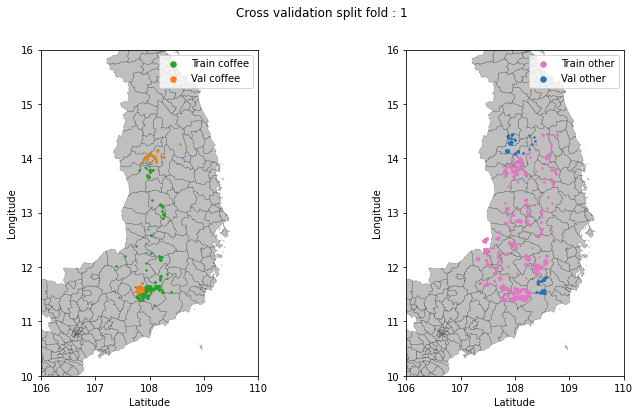

In [10]:
NB_FOLD = 1
for i_fold in range(0, NB_FOLD):
    geo_train = gpd.GeoDataFrame(pd.read_csv(os.path.join("datasets","coffee_10fold",f"train_{i_fold+1}_data.csv")))
    geo_train['geometry'] = geo_train['geometry'].apply(wkt.loads)
    
    geo_val = gpd.GeoDataFrame(pd.read_csv(os.path.join("datasets","coffee_10fold",f"val_{i_fold+1}_data.csv")))
    geo_val['geometry'] = geo_val['geometry'].apply(wkt.loads)

    display_cross_val_map_class(geo_train, geo_val, vietnam, f"Cross validation split fold : {i_fold+1}")
    
    print(f"Fold {i_fold+1} Number coffee - train : {len(geo_train[geo_train['label'] == 0])}")
    print(f"Fold {i_fold+1} Number no-coffee - train : {len(geo_train[geo_train['label'] == 1])}")

    print(f"Fold {i_fold+1} Number coffee - val : {len(geo_val[geo_val['label'] == 0 ])}")
    print(f"Fold {i_fold+1} Number no-coffee - val : {len(geo_val[geo_val['label'] == 1])}")
    print(f"Training for fold {i_fold+1}")

    print("-----")
    
    train_generator = generator(geo_train['path'].to_numpy(), 
                                  geo_train['label'].to_numpy(), 
                                  eurosat_params['mean'], 
                                  eurosat_params['std'], 
                                  batch_size=BATCH_SIZE, 
                                  is_data_augmentation=True)

    validation_generator = generator(geo_val['path'].to_numpy(), 
                                geo_val['label'].to_numpy(), 
                                eurosat_params['mean'], 
                                eurosat_params['std'], 
                                batch_size=BATCH_SIZE, 
                                is_data_augmentation=True)


    earlystopper = EarlyStopping(monitor='accuracy',patience=20,restore_best_weights=True)
      
    model = create_model()

    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',metrics=METRICS)

    history = model.fit(train_generator,
                        epochs=EPOCH,
                        steps_per_epoch=(len(geo_train)//BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        validation_data=validation_generator,
                        validation_steps=(len(geo_val)//BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        callbacks=[earlystopper],
                        class_weight=class_weight)

    #model.save(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + '_'+ str(i_fold) +'.h5'))

    #np.save(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + '_'+ str(i_fold) +'.npy'),history.history)
    
    result = model.evaluate(validation_generator,steps=4)
    results.append(result)
    
    print(f"Fold {i_fold+1} loss : {result[0]}")
    print(f"Fold {i_fold+1} accuracy : {result[1]}")
    print(f"Fold {i_fold+1} F1-score : {result[4]}")
    
    compute_score(geo_val, model)

    print("\n")

    K.clear_session()

In [13]:
with open(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + ".json"),'w') as fp:
    json.dump(results, fp)

In [14]:
losses, accs, precisions, recalls, f1_scores = zip(*results)

print(f"Mean accuracy : {np.mean(accs)}")
print(f"Stdev accuracy : {np.std(accs)}")
print("\n")
print(f"Mean loss : {np.mean(losses)}")
print(f"Stdev loss : {np.std(losses)}")
print("\n")
print(f"Mean precision : {np.mean(precisions)}")
print(f"Stdev precision : {np.std(precisions)}")
print("\n")
print(f"Mean recall : {np.mean(recalls)}")
print(f"Stdev recall : {np.std(recalls)}")
print("\n")
print(f"Mean F1-Score : {np.mean(f1_scores)}")
print(f"Stdev F1-Score : {np.std(f1_scores)}")

Mean accuracy : 0.99921875
Stdev accuracy : 0.0015625


Mean loss : 0.10380962193012237
Stdev loss : 0.04438709109165909


Mean precision : 0.9988372087478637
Stdev precision : 0.002325582504272461


Mean recall : 1.0
Stdev recall : 0.0


Mean F1-Score : 0.999397587776184
Stdev F1-Score : 0.0012048244476318359


In [22]:
geo_test= gpd.GeoDataFrame(pd.read_csv(os.path.join("datasets","coffee_10fold",f"test_data.csv")))
geo_test['geometry'] = geo_test['geometry'].apply(wkt.loads)

In [23]:
restored_model = load_model(os.path.join("saved_models/from_scratch/Coffee/final_spacv_10FOLD_coffee1/final_spacv_10FOLD_coffee1_0.h5"), custom_objects={'LeakyReLU':LeakyReLU}, compile=False)
restored_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',metrics=METRICS)


In [24]:
test_generator = generator(geo_test['path'].to_numpy(), 
                            geo_test['label'].to_numpy(), 
                            eurosat_params['mean'], 
                            eurosat_params['std'], 
                            batch_size=len(geo_test))

In [25]:
restored_model.evaluate(test_generator, steps=1)

1/1 [==============================] - 4s 4s/step - loss: 0.1473 - accuracy: 0.9940 - precision: 0.9973 - recall: 0.9946 - f1_score_keras: 0.9964


[0.14732344448566437,
 0.9939758777618408,
 0.9972752332687378,
 0.9945651888847351,
 0.9963701963424683]

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       195
           1       1.00      0.99      1.00       552

    accuracy                           0.99       747
   macro avg       0.99      1.00      0.99       747
weighted avg       0.99      0.99      0.99       747

F1-Score : 0.9963636363636363


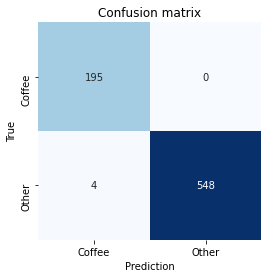

In [26]:
Y_true = []
Y_pred = []
for i in range (0,1):
    X, Y = next(test_generator)
    Y_pred.extend(np.where(restored_model.predict(X) > 0.5, 1, 0))

    Y_true.extend(Y.tolist())
    
Y_true = np.asarray(Y_true)
Y_pred = np.asarray(Y_pred)
cm = confusion_matrix(Y_true, Y_pred)
plot_confusion_matrix(cm, ["Coffee", "Other"])
print(classification_report(Y_true, Y_pred))
print(f"F1-Score : {f1_score(Y_true, Y_pred)}")

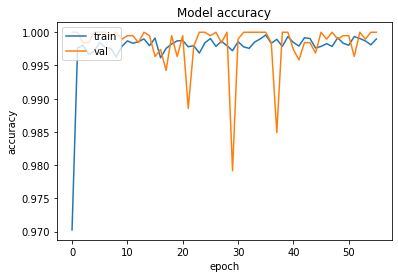

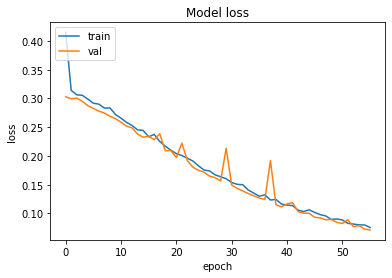

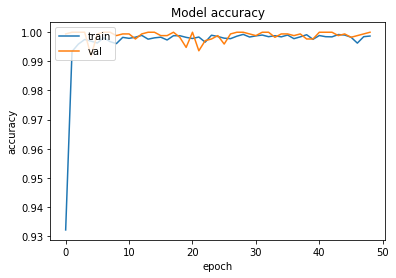

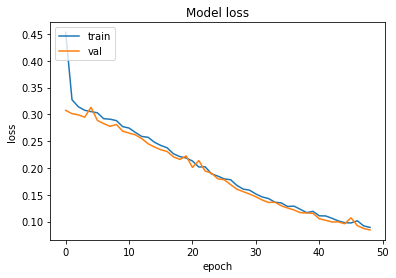

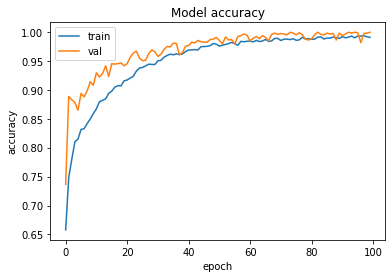

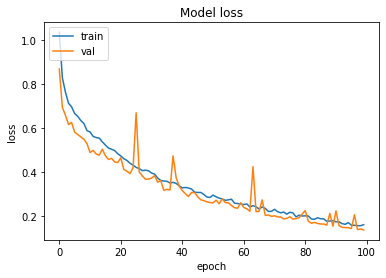

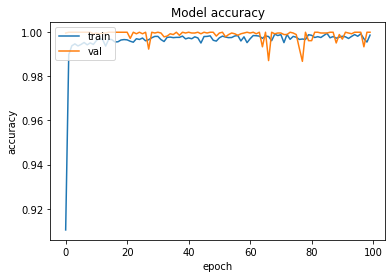

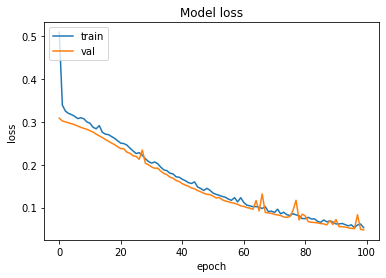

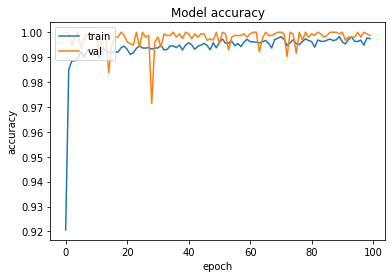

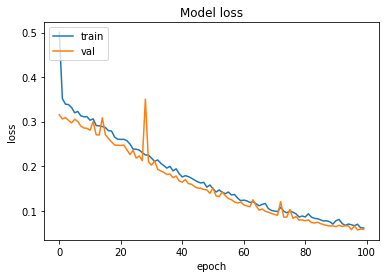

In [37]:
a = os.path.join(SAVED_MODELS_PATH, 'Coffee', 'final_spacv_10FOLD_coffee1')
for i in os.listdir(a):
    if(i.split('.')[1] == 'npy'):
        chart = np.load(os.path.join(a, i), allow_pickle=True).item()
        
        # summarize history for accuracy
        plt.plot(chart['accuracy'])
        plt.plot(chart['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()

        # summarize history for loss
        plt.plot(chart['loss'])
        plt.plot(chart['val_loss'])
        plt.title('Model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()

In [39]:
geo_train= gpd.GeoDataFrame(pd.read_csv(os.path.join("datasets","coffee_10fold",f"train_data.csv")))
geo_train['geometry'] = geo_train['geometry'].apply(wkt.loads)

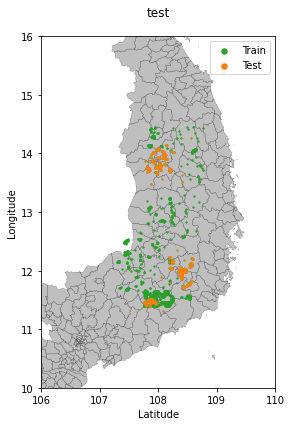

In [44]:
display_cross_val_map(geo_train, geo_test, vietnam, "test")
